## TEMPLATE MATCHING
Through template matching we can find the location of provided template in the larger picture. \
cv.matchTemplate compares the template to the entire image and calculates how well the template matches each possible position in the image. \
This function uses similarity score and for each position, the function calculates a score (in the case of cv2.TM_CCORR_NORMED, it’s a normalized correlation score). The higher the score, the better the match.
- TM_CCORR_NORMED - This method calculates the normalized cross-correlation, higher values -> better matches
- TM_SQDIFF - This method calculates the sum of squared differences, lower values -> better matches

After template matching we can use min_val, max_val, min_loc, max_loc = cv.minMaxLoc() to get the location of an object.
- min_val -> minimum value found in the matrix res, it's the lowest correlation score
- max_val -> maximum value found in the matrix res, it's the highest correlation score
- min_loc -> location of the min_val
- max_loc -> location of the max_val

In [ ]:
import cv2
from matplotlib import pyplot as plt

plt.gray()

img = cv2.imread("pics/playtable_left.png")

img_left = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)


template = cv2.imread('pics/crocodile.png')
# Though the template is saved as a single channel (grayscale) image, it is loaded as a 3 channel image with identical channels.
# Therefore we can just take any of the three channels
template = template[...,0]


res = cv2.matchTemplate(gray_left, template, cv2.TM_CCORR_NORMED)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

top_left = max_loc
bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])

crocodile = cv2.rectangle(img_left.copy(), top_left, bottom_right, (255,0,0), 3)



fig, axes = plt.subplots(1, 3, figsize=(20, 20)) 

axes[0].imshow(gray_left)
axes[0].axis('off')
axes[0].set_title('Base image')

axes[1].imshow(res)
axes[1].axis('off')
axes[1].set_title('Image after cv.matchTemplate')

axes[2].imshow(crocodile)
axes[2].axis('off')
axes[2].set_title('Located crocodile')



## STEREO VISION
- Baseline: the line connecting the two camera centers
- Epipolar plane: the plane that contains the two camera centers and a 3D point in the world
- Epipolar line: intersection of the epipolar plane with each image plane

Key concepts:
- Disparity: The horizontal shift (difference in x-coordinates) of corresponding points in the left and right images. The more a point shifts between the two images, the closer it is to the cameras. \
disparity = x_left - x_right
- Before doing anything with the pictures we need to rectify them. It’s important to ensure that both images are aligned (rectified). This step ensures that corresponding points in the two images are along the same horizontal lines, which simplifies the disparity computation
- Block matching: The idea is to find corresponding blocks of pixels in one image in the other image. It's just finding similar spots on both pictures and matching them.

### Stereo block matching
stereo = cv2.StereoBM_create(numDisparities = num_disp, blockSize = block_size)
stereo.setMinDisparity(min_disp) \
stereo.setDisp12MaxDiff(200) \
stereo.setUniquenessRatio(1) \
stereo.setSpeckleRange(3) \
stereo.setSpeckleWindowSize(3)
- min_disp - minimal horizostal shift (disparity) that the algorithm will consider
- num_disp - it's the range of disparities that the algorithm will consider (it's essentially max_disp = min_disp + num_disp)
- block_size - determines the size of the blocks (windows), the algorithm will search for a matching block of this size in the other picture
- setDisp12MaxDiff - this sets the maximum allowed difference (in disparity) between the left and right images at the same pixel position.
- setUniquenessRatio - the uniqueness ratio is a measure of how unique the best match needs to be. This controls how similar the best match should be compared to the second-best match.
A lower value (like 1) means the best match must be only slightly better than the second-best. This can help avoid ambiguous matches, but may result in more false positives (matches that don't make sense).
- setSpeckleRange - The speckle range parameter is used to filter out small isolated noise regions that may appear as mismatched areas in the disparity map.
A value of 3 means that disparity differences larger than 3 pixels between neighboring pixels will be considered as noise and removed, helping to reduce speckle noise.
- setSpeckleWindowSize - The speckle window size defines the size of the window used for filtering out small regions of noise.
A value of 3 means a 3x3 window is used for speckle filtering. The disparity difference within this window will be checked, and if the difference exceeds the speckle range, the region will be treated as noise and discarded.


Disparity is inversely proportional to depth:

Depth = (f × B) / Disparity

### Variables:
- **\( f \)**: Camera focal length
- **\( B \)**: Baseline (distance between the two cameras)
- **Disparity**: The value from the disparity map


In the final disparity image:
- Brighter pixels represent higher disparity (closer objects).
- Darker pixels represent lower disparity (farther objects).

### CV.RESIZE(img, size, interpolation)
- interpolation - cv.INTER_AREA is generally preferred for shrinking an image (downscaling), as it produces better results by considering pixel area relationships. cv.INTER_LINEAR is good for upscaling, default method.

Text(0.5, 1.0, 'Disparity map')

<Figure size 640x480 with 0 Axes>

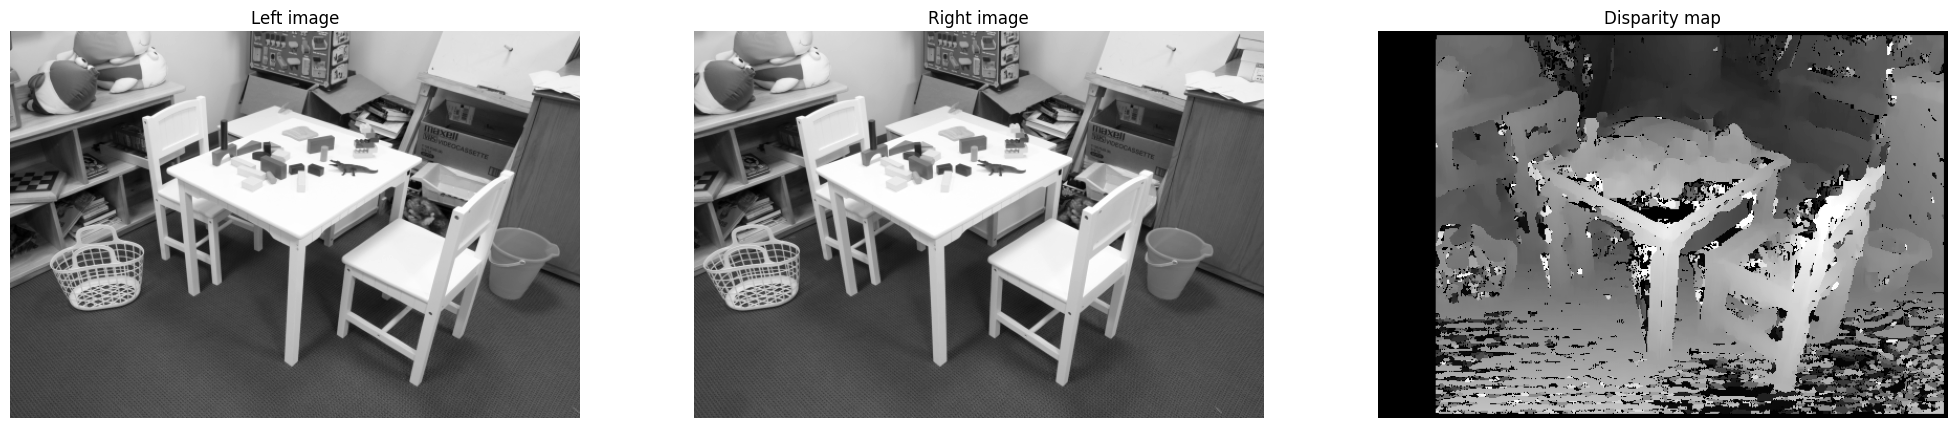

In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data

plt.gray()

# load the images
img_left = cv2.imread("pics/playtable_left.png")
img_right = cv2.imread("pics/playtable_right.png")

# rescale images (can be left out)
img_size = (int(img_left.shape[1]/5), int(img_left.shape[0]/5))
img_left = cv2.resize(img_left, img_size, interpolation=cv2.INTER_AREA)
img_right = cv2.resize(img_right, img_size, interpolation=cv2.INTER_AREA)

# convert images to grayscale for template matching
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)


min_disp = 4
num_disp = 3 * 16
block_size = 9
stereo = cv2.StereoBM_create(numDisparities = num_disp, blockSize = block_size)
stereo.setMinDisparity(min_disp)
stereo.setDisp12MaxDiff(200)
stereo.setUniquenessRatio(1)
stereo.setSpeckleRange(11)
stereo.setSpeckleWindowSize(5)

disp = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0


fig, axes = plt.subplots(1, 3, figsize=(25, 25)) 

axes[0].imshow(gray_left)
axes[0].axis('off')
axes[0].set_title('Left image')

axes[1].imshow(gray_right)
axes[1].axis('off')
axes[1].set_title('Right image')

axes[2].imshow(disp)
axes[2].axis('off')
axes[2].set_title('Disparity map')


### POINT CLOUD
A point cloud is a collection of data points in 3D space, typically used to represent the external surface of an object or scene. Each point in the point cloud has coordinates (x,y,z)(x,y,z) that define its position in 3D space. Some point clouds also include additional information, such as color (r,g,br,g,b) or intensity.

In [ ]:
def export_pointcloud(disparity_map, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''

    def write_ply(fn, verts, colors):
        verts = verts.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open(fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

    h, w = disparity_map.shape[:2]
    f = .8 * w  # guess for focal length. If you 3D reconstruction looks skewed in the viewing direction, try adjusting this parameter.
    Q = np.float32([[1, 0, 0, -0.5 * w],
                    [0, -1, 0, 0.5 * h],  # turn points 180 deg around x-axis,
                    [0, 0, 0, -f],  # so that y-axis looks up
                    [0, 0, 1, 0]])
    points = cv2.reprojectImageTo3D(disparity_map, Q)
    
    mask = disparity_map > disparity_map.min()
    out_points = points[mask]
    out_colors = colors[mask]
    out_fn = 'out.ply'
    write_ply('out.ply', out_points, out_colors)
    print(f'{out_fn} saved')

export_pointcloud(disparity_map=disp, colors=img_left)

## Other definitions and stuff
The epipoles lie on the baseline-containing line
The baseline intersects the epipolar plane at the epipoles
All epipolar lines intersect at the epipoles

All epipolar lines meet at the optical center
All epipolar lines are parallel  to the optical axis

The epipoles can be outside the images

## Image dissimilarity
The dissimilarity between two matrices \( A \) and \( B \) is given by the formula:

$$
D = \sum_{i=1}^{3} \sum_{j=1}^{3} (A_{ij} - B_{ij})^2
$$





$$
\begin{bmatrix}
u \\
v \\
w
\end{bmatrix}
=
K \cdot
\begin{bmatrix}
R & t
\end{bmatrix}
\cdot
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
$$


$$
\text{Camera matrix } K
$$
$$
K =
\begin{bmatrix}
725 & 0 & 631 \\
0 & 726 & 360 \\
0 & 0 & 1
\end{bmatrix}
$$

$$
\text{Rotation matrix } R
$$
$$
R =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

$$
\text{Project into image plane}
$$
$$
\begin{bmatrix} u \\ v \\ w \end{bmatrix}
=
\begin{bmatrix}
725 & 0 & 631 \\
0 & 726 & 360 \\
0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
1 \\
1 \\
5
\end{bmatrix}
=
\begin{bmatrix}
725 \cdot 1 + 0 \cdot 1 + 631 \cdot 5 \\
0 \cdot 1 + 726 \cdot 1 + 360 \cdot 5 \\
1 \cdot 5
\end{bmatrix}
=
\begin{bmatrix}
3680 \\
2160 \\
5
\end{bmatrix}
$$

$$
\text{Normalize to find pixel coordinates}
$$
$$
u = \frac{3680}{5} = 736
$$
$$
v = \frac{2160}{5} = 432
$$
